# Importing Libraries

In [7]:
import gc
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from keras import layers
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.models import Sequential

from keras import backend as K
from tensorflow.keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [8]:
# Importing Data
data = pd.read_csv('../input/breakhis/Folds.csv')

# Image Directory
img_dir = '../input/breakhis/BreaKHis_v1/'

# Class Labels
class_names = ['benign', 'malignant']

# Data Pre-processing

In [9]:
# Renaming Column
if 'path' not in data.columns:
    data = data.rename(columns={'filename':'path'})

# Adding Columns with useful data
if 'label' or 'label_int' or 'filename' not in data.columns:
    data['label'] = data.path.apply(lambda x: x.split('/')[3])
    data['label_int'] = data.label.apply(lambda x: class_names.index(x))
    data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

# Printing Useful information
print("Data Shape: ", data.shape)
print("Folds: ", data.fold.unique())
print("Magnifications: ", data.mag.unique())
print("Labels: ", data.label.unique(), data.label_int.unique())

print("Dataset:")
data.head(3)

Data Shape:  (39545, 7)
Folds:  [1 2 3 4 5]
Magnifications:  [100 200  40 400]
Labels:  ['benign' 'malignant'] [0 1]
Dataset:


,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-003.png


### Visualizing Label Counts

Count of Benign    :  2480.0
Count of Malignant :  5429.0


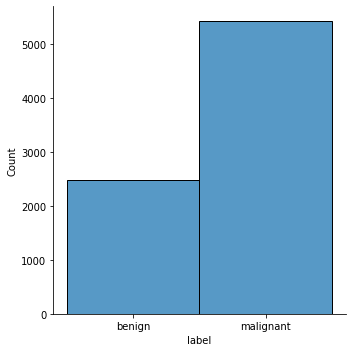

In [10]:
ax = sns.displot(data=data.iloc[0:7909], x='label')
print('Count of Benign    : ', data[data.label == 'benign'].label.count()/5)
print('Count of Malignant : ', data[data.label == 'malignant'].label.count()/5)

### Categorizing Data using Magnifications

Magnification: 100
malignant    1437.0
benign        644.0
Name: label, dtype: float64 

Magnification: 200
malignant    1390.0
benign        623.0
Name: label, dtype: float64 

Magnification: 40
malignant    1370.0
benign        625.0
Name: label, dtype: float64 

Magnification: 400
malignant    1232.0
benign        588.0
Name: label, dtype: float64 



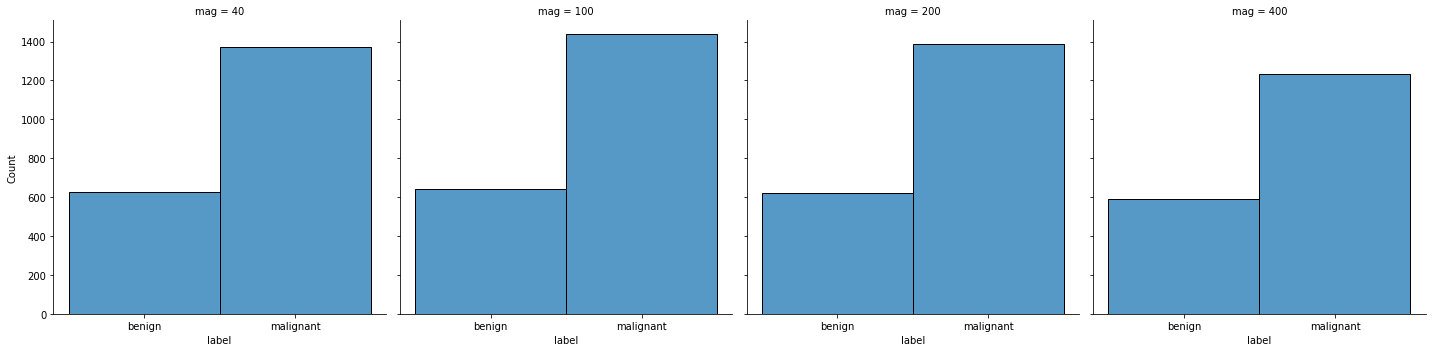

In [11]:
# Plotting Data for all magnifications
ax = sns.displot(data=data.iloc[0:7909], x='label', col='mag')

# Data Dict
data_dict = {}

# Categorizing for all mags
for mag in data['mag'].unique():
    data_dict[mag]=data.loc[data['mag'] == mag].copy()
    print('Magnification:', mag)
    print(data_dict[mag].label.value_counts()/5, "\n")

### Load and View Images

In [12]:
img_width = 224
img_height = 224
dim = (img_width, img_height)

# Iterating on Mags
for mag in data['mag'].unique():
    # Initializing images column
    data_dict[mag]['img_read'] = np.nan
    data_dict[mag]['img_read'] = data_dict[mag]['img_read'].astype(object)

    # Printing Info
    print("[INFO] Importing Images for Magnification",mag)

    # Iterating on all rows and reading image data
    for index, row in tqdm(data_dict[mag].iterrows(), total=data_dict[mag].shape[0]):
        img = cv2.imread(img_dir + row.path)
        if img.shape != (img_width, img_height, 3):
            img = cv2.resize(img, dim)
        data_dict[mag].at[index, 'img_read'] = img

[INFO] Importing Images for Magnification 100


100%|██████████| 10405/10405 [02:07<00:00, 81.45it/s]


[INFO] Importing Images for Magnification 200


100%|██████████| 10065/10065 [02:16<00:00, 73.52it/s]


[INFO] Importing Images for Magnification 40


100%|██████████| 9975/9975 [02:15<00:00, 73.39it/s] 


[INFO] Importing Images for Magnification 400


100%|██████████| 9100/9100 [02:04<00:00, 73.11it/s] 


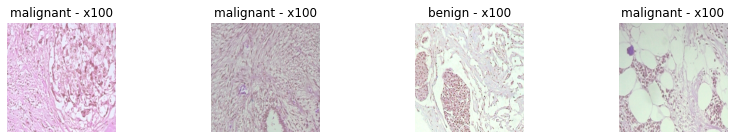

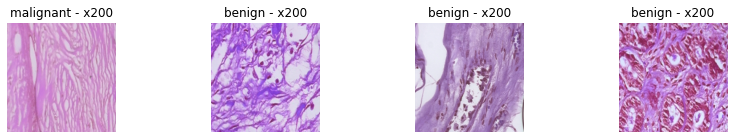

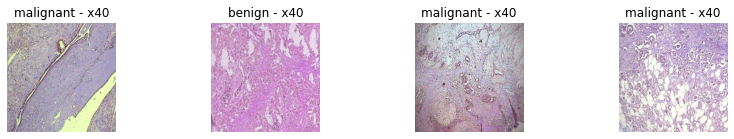

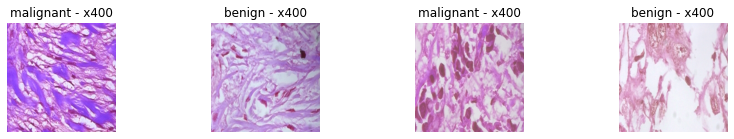

In [13]:
row = 1
col = 4
per_mag = 4

for mag in data['mag'].unique():
    fig, axes = plt.subplots(row, col, figsize=(3.5*col,2*row))
    for images, labels, i in zip(data_dict[mag].sample(per_mag).iloc[:, 7],
                                 data_dict[mag].sample(per_mag).iloc[:, 4],
                                 range(per_mag)):
        ax = axes[i]
        ax.imshow(images)
        ax.set_title(labels+" - x"+str(mag))
        ax.axis("off") 
    plt.show()

In [14]:
EPOCHS = 10
INIT_LR = 1e-4
BATCH_SIZE = 16
INPUT_SHAPE = (224,224,3)

In [15]:
def build_model(backbone, lr=INIT_LR):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=lr),
                  metrics=['accuracy'])
    
    return model

In [16]:
# Early stop to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [17]:
datagen = ImageDataGenerator(rescale=1 / 255.0,
                              rotation_range=20,
                              zoom_range=0.05,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.05,
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode="nearest")

In [18]:
def Train(mag, fold):
    # Train Data
    X_train = np.stack(data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="train")].img_read.to_list())
    y_train = data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="train")].label_int.to_list()
    y_train = to_categorical(y_train, num_classes= 2)

    # Test Data
    X_test = np.stack(data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="test")].img_read.to_list())
    y_test = data_dict[mag][(data_dict[mag]["fold"]==fold) & (data_dict[mag]["grp"]=="test")].label_int.to_list()

    # Validation Data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)
    
    # Initializing Model
    K.clear_session()
    gc.collect()
    DenseNet201_model = DenseNet201(weights='imagenet',
                                    include_top=False,
                                    input_shape=INPUT_SHAPE)
    model = build_model(DenseNet201_model , lr = INIT_LR)
    
    print("--------------------------------------------------------------------------------------------")
    print("                               [INFO] Training Model")
    print("--------------------------------------------------------------------------------------------")
    
    # Fit Model
    history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                         steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                         epochs= EPOCHS,
                         validation_data=(X_val/255, y_val),
                         callbacks=[early_stop],
                         verbose=1)
    
    print("--------------------------------------------------------------------------------------------")
    print("                               [INFO] Evaluating Model")
    print("--------------------------------------------------------------------------------------------")
    # Evaluate model
    model.evaluate(X_val/255, y_val)

    y_pred = model.predict(X_test/255)
    y_pred = np.argmax(y_pred,axis=1)
    
    return model, history, y_test, y_pred

In [19]:
def History_metrics(history):    
    sns.set()

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    #accuracy plot
    plt.plot(epochs, accuracy, color='b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, color='r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.figure()
    #loss plot
    plt.plot(epochs, loss, color='g', label='Training Loss')
    plt.plot(epochs, val_loss, color='y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [20]:
def Model_report(y_test, y_pred):
    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='g')
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [21]:
mag_acc=np.empty((4,1))

# Magnification: 100x

In [22]:
mag =100

## Fold 2

In [23]:
m, history, y_test, y_pred = Train(mag, 2)

2022-01-07 00:20:58.238001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 00:20:58.332953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 00:20:58.333634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 00:20:58.334684: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

74850304/74836368 [==============================] - 1s 0us/step
--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------


2022-01-07 00:21:08.468583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-01-07 00:21:26.275231: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


73/73 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.6558

2022-01-07 00:21:51.551249: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 176418816 exceeds 10% of free system memory.
2022-01-07 00:21:51.796846: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 176418816 exceeds 10% of free system memory.


73/73 [==============================] - 49s 328ms/step - loss: 0.7066 - accuracy: 0.6558 - val_loss: 0.6314 - val_accuracy: 0.6587
Epoch 2/10
73/73 [==============================] - 19s 254ms/step - loss: 0.4336 - accuracy: 0.8647 - val_loss: 0.6652 - val_accuracy: 0.6587
Epoch 3/10
73/73 [==============================] - 18s 244ms/step - loss: 0.3090 - accuracy: 0.9144 - val_loss: 0.5771 - val_accuracy: 0.7099
Epoch 4/10
73/73 [==============================] - 20s 266ms/step - loss: 0.2680 - accuracy: 0.9358 - val_loss: 0.4400 - val_accuracy: 0.7986
Epoch 5/10
73/73 [==============================] - 19s 255ms/step - loss: 0.2694 - accuracy: 0.9332 - val_loss: 0.4258 - val_accuracy: 0.7918
Epoch 6/10
73/73 [==============================] - 19s 256ms/step - loss: 0.2196 - accuracy: 0.9640 - val_loss: 0.2672 - val_accuracy: 0.8805
Epoch 7/10
73/73 [==============================] - 19s 257ms/step - loss: 0.1957 - accuracy: 0.9580 - val_loss: 0.1178 - val_accuracy: 0.9693
Epoch 8/10

2022-01-07 00:24:45.404135: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 176418816 exceeds 10% of free system memory.
2022-01-07 00:24:45.618918: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 176418816 exceeds 10% of free system memory.


10/10 [==============================] - 1s 90ms/step - loss: 0.0835 - accuracy: 0.9829


2022-01-07 00:24:47.710565: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 373309440 exceeds 10% of free system memory.


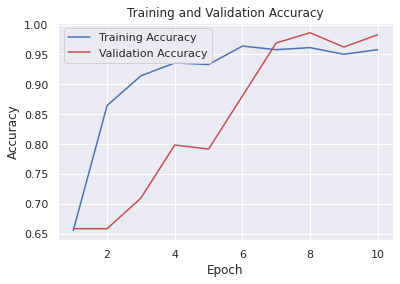

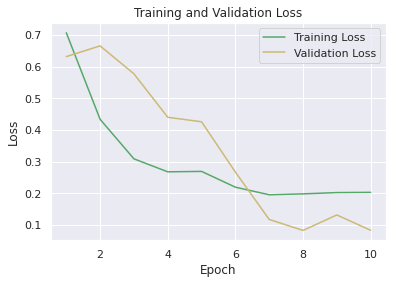

In [24]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       195
           1       0.92      0.89      0.91       425

    accuracy                           0.87       620
   macro avg       0.85      0.86      0.86       620
weighted avg       0.88      0.87      0.87       620



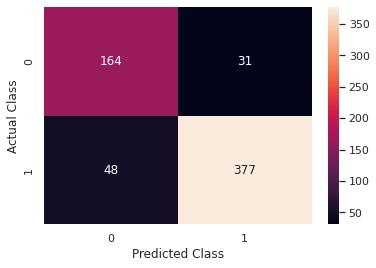

In [25]:
mag_acc[0] = Model_report(y_test, y_pred)

In [26]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model100.save("models/trained_bin_100_1")

# Magnification: 200x

In [27]:
mag = 200

## Fold 2

In [28]:
m, history, y_test, y_pred = Train(mag, 2)

--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------
Epoch 1/10
70/70 [==============================] - 41s 341ms/step - loss: 0.7035 - accuracy: 0.6458 - val_loss: 0.6224 - val_accuracy: 0.6585
Epoch 2/10
70/70 [==============================] - 18s 256ms/step - loss: 0.4592 - accuracy: 0.8463 - val_loss: 0.6453 - val_accuracy: 0.6479
Epoch 3/10
70/70 [==============================] - 17s 243ms/step - loss: 0.3559 - accuracy: 0.8993 - val_loss: 0.5629 - val_accuracy: 0.6796
Epoch 4/10
70/70 [==============================] - 18s 251ms/step - loss: 0.2972 - accuracy: 0.9134 - val_loss: 0.2839 - val_accuracy: 0.8803
Epoch 5/10
70/70 [==============================] - 18s 249ms/step - loss: 0.2280 - accuracy: 0.9549 - val_loss: 0.2979 - val_accuracy: 0.8627
Epoch 6/10
70/70 [============================

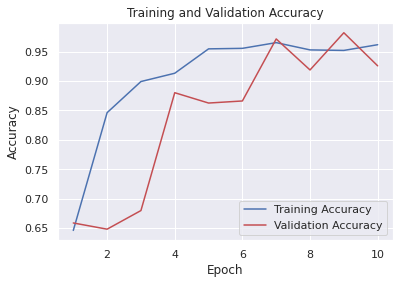

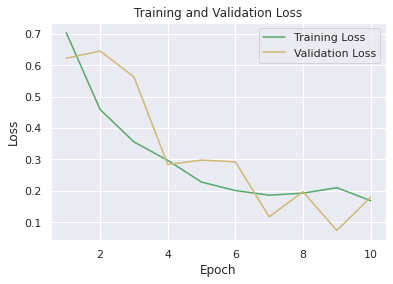

In [29]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.86      0.68      0.76       168
           1       0.89      0.96      0.92       429

    accuracy                           0.88       597
   macro avg       0.88      0.82      0.84       597
weighted avg       0.88      0.88      0.88       597



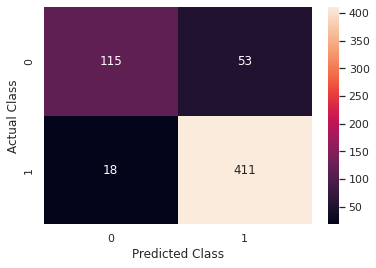

In [30]:
mag_acc[1] = Model_report(y_test, y_pred)

In [31]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model200.save("models/trained_bin_200_1")

# Magnification: 40x

In [32]:
mag = 40

## Fold 2

In [42]:
m, history, y_test, y_pred = Train(mag, 2)

--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------
Epoch 1/10
63/63 [==============================] - 37s 302ms/step - loss: 0.7456 - accuracy: 0.5771 - val_loss: 0.6176 - val_accuracy: 0.6850
Epoch 2/10
63/63 [==============================] - 17s 262ms/step - loss: 0.5289 - accuracy: 0.7856 - val_loss: 0.7562 - val_accuracy: 0.6575
Epoch 3/10
63/63 [==============================] - 16s 251ms/step - loss: 0.3538 - accuracy: 0.8794 - val_loss: 0.7000 - val_accuracy: 0.6614
Epoch 4/10
63/63 [==============================] - 16s 253ms/step - loss: 0.2863 - accuracy: 0.9249 - val_loss: 0.3218 - val_accuracy: 0.8661
Epoch 5/10
63/63 [==============================] - 16s 248ms/step - loss: 0.2884 - accuracy: 0.9269 - val_loss: 0.2063 - val_accuracy: 0.9409
Epoch 6/10
63/63 [============================

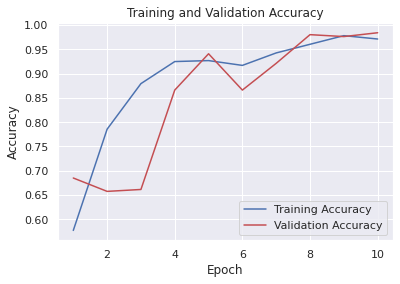

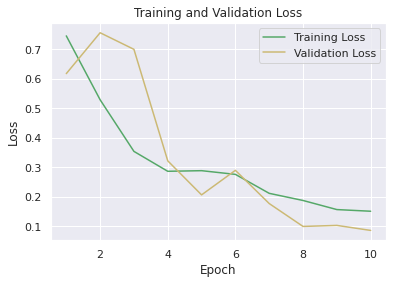

In [43]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       169
           1       0.86      0.86      0.86       385

    accuracy                           0.80       554
   macro avg       0.77      0.77      0.77       554
weighted avg       0.80      0.80      0.80       554



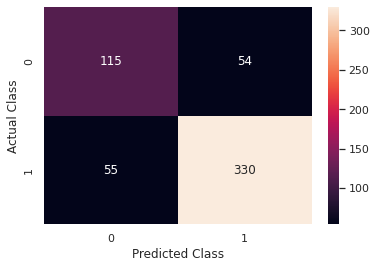

In [44]:
mag_acc[2] = Model_report(y_test, y_pred)

In [36]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model40.save("models/trained_bin_40_1")

# Magnification: 400x

In [37]:
mag = 400

## Fold 2

In [38]:
m, history, y_test, y_pred = Train(mag, 2)

--------------------------------------------------------------------------------------------
                               [INFO] Training Model
--------------------------------------------------------------------------------------------
Epoch 1/10
63/63 [==============================] - 38s 325ms/step - loss: 0.6391 - accuracy: 0.6670 - val_loss: 0.6515 - val_accuracy: 0.6457
Epoch 2/10
63/63 [==============================] - 17s 264ms/step - loss: 0.4497 - accuracy: 0.8103 - val_loss: 0.6582 - val_accuracy: 0.6575
Epoch 3/10
63/63 [==============================] - 16s 249ms/step - loss: 0.3565 - accuracy: 0.8864 - val_loss: 0.6556 - val_accuracy: 0.6693
Epoch 4/10
63/63 [==============================] - 16s 253ms/step - loss: 0.3024 - accuracy: 0.9239 - val_loss: 0.4994 - val_accuracy: 0.7441
Epoch 5/10
63/63 [==============================] - 16s 251ms/step - loss: 0.2774 - accuracy: 0.9219 - val_loss: 0.3057 - val_accuracy: 0.8701
Epoch 6/10
63/63 [============================

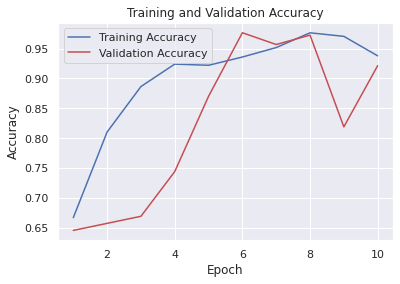

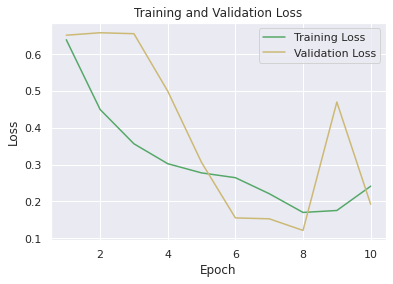

In [39]:
History_metrics(history)

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       169
           1       0.87      0.92      0.89       385

    accuracy                           0.85       554
   macro avg       0.83      0.80      0.81       554
weighted avg       0.84      0.85      0.84       554



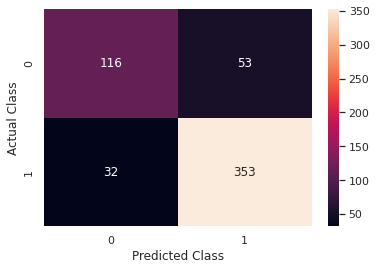

In [40]:
mag_acc[3] = Model_report(y_test, y_pred)

In [41]:
# Save the model to disk
#print("[INFO] Serializing network...")
#model400.save("models/trained_bin_400_1")